# Synthetic Moho Model from Uieda et al. 2017.

Here we attempt to reproduce the simple synthetic Moho inversion from [Uieda et al. 2017:](https://doi.org/10.1093/gji/ggw390) Fast nonlinear gravity inversion in spherical coordinates with application to the South American Moho. They provide functions for creating synthetic Moho topography, which we forward model to create the observed gravity data to use for the inversion.

In [1]:
# set EPSG for plotting functions
import os

import numpy as np
import polartoolkit as ptk
import pyproj
import scipy as sp
import verde as vd

import invert4geom

os.environ["POLARTOOLKIT_EPSG"] = "3857"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Recreate synthetic topography 
Here we recreate the synthetic topography model from the paper. We slightly update their code for creating this, and use projected coordinates instead of geographic coordinates, but the models are as similar as possible to the original.

In [2]:
def gaussian2d(x, y, sigma_x, sigma_y, x0=0, y0=0, angle=0.0):
    """
    Taken from https://legacy.fatiando.org/api/utils.html#fatiando.utils.gaussian2d
    which is used in Uieda et al. 2017 paper.
    """
    theta = -1 * angle * np.pi / 180.0
    tmpx = 1.0 / sigma_x**2
    tmpy = 1.0 / sigma_y**2
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    a = tmpx * costheta + tmpy * sintheta**2
    b = (tmpy - tmpx) * costheta * sintheta
    c = tmpx * sintheta**2 + tmpy * costheta**2
    xhat = x - x0
    yhat = y - y0
    return np.exp(-(a * xhat**2 + 2.0 * b * xhat * yhat + c * yhat**2))

In [3]:
# Make a regular grid inside an area.
# Grid points will be the center of the top of each tesseroid in the model
shape = (40, 50)  # n, e
region_ll = (-50, 50, 10, 70)  # e, n
lon, lat = vd.grid_coordinates(region=region_ll, shape=shape)

relief = (
    -30e3
    + 15e3 * sp.special.erf((lon - 10) / 20)
    - 10e3 * gaussian2d(lat, lon, 10, 15, x0=25, y0=-30)
    + 10e3 * gaussian2d(lat, lon, 15, 20, x0=53, y0=-25)
    - 10e3 * gaussian2d(lat, lon, 3, 3, x0=50, y0=30)
    - 10e3 * gaussian2d(lat, lon, 10, 10, x0=30, y0=25) ** 2
    + 5e3 * gaussian2d(lat, lon, 40, 3, x0=40, y0=40, angle=15)
)

relief = vd.make_xarray_grid((lon, lat), relief, data_names="upward")

# We're choosing the latitude of true scale as the mean latitude of our dataset
projection = pyproj.Proj(proj="merc", lat_ts=lat.mean())

true_moho = vd.project_grid(
    relief.upward,
    projection,
    spacing=50e3,
    adjust="region",
)

true_moho = ptk.resample_grid(
    true_moho,
    spacing=200e3,
).rename({"x": "easting", "y": "northing"})
true_moho = true_moho.to_dataset(name="upward")
true_moho

<xarray.Dataset> Size: 7kB
Dimensions:   (northing: 38, easting: 43)
Coordinates:
  * northing  (northing) float64 304B 1e+06 1.2e+06 1.4e+06 ... 8.2e+06 8.4e+06
  * easting   (easting) float64 344B -4.2e+06 -4e+06 -3.8e+06 ... 4e+06 4.2e+06
Data variables:
    upward    (northing, easting) float32 7kB -4.534e+04 ... -1.291e+04

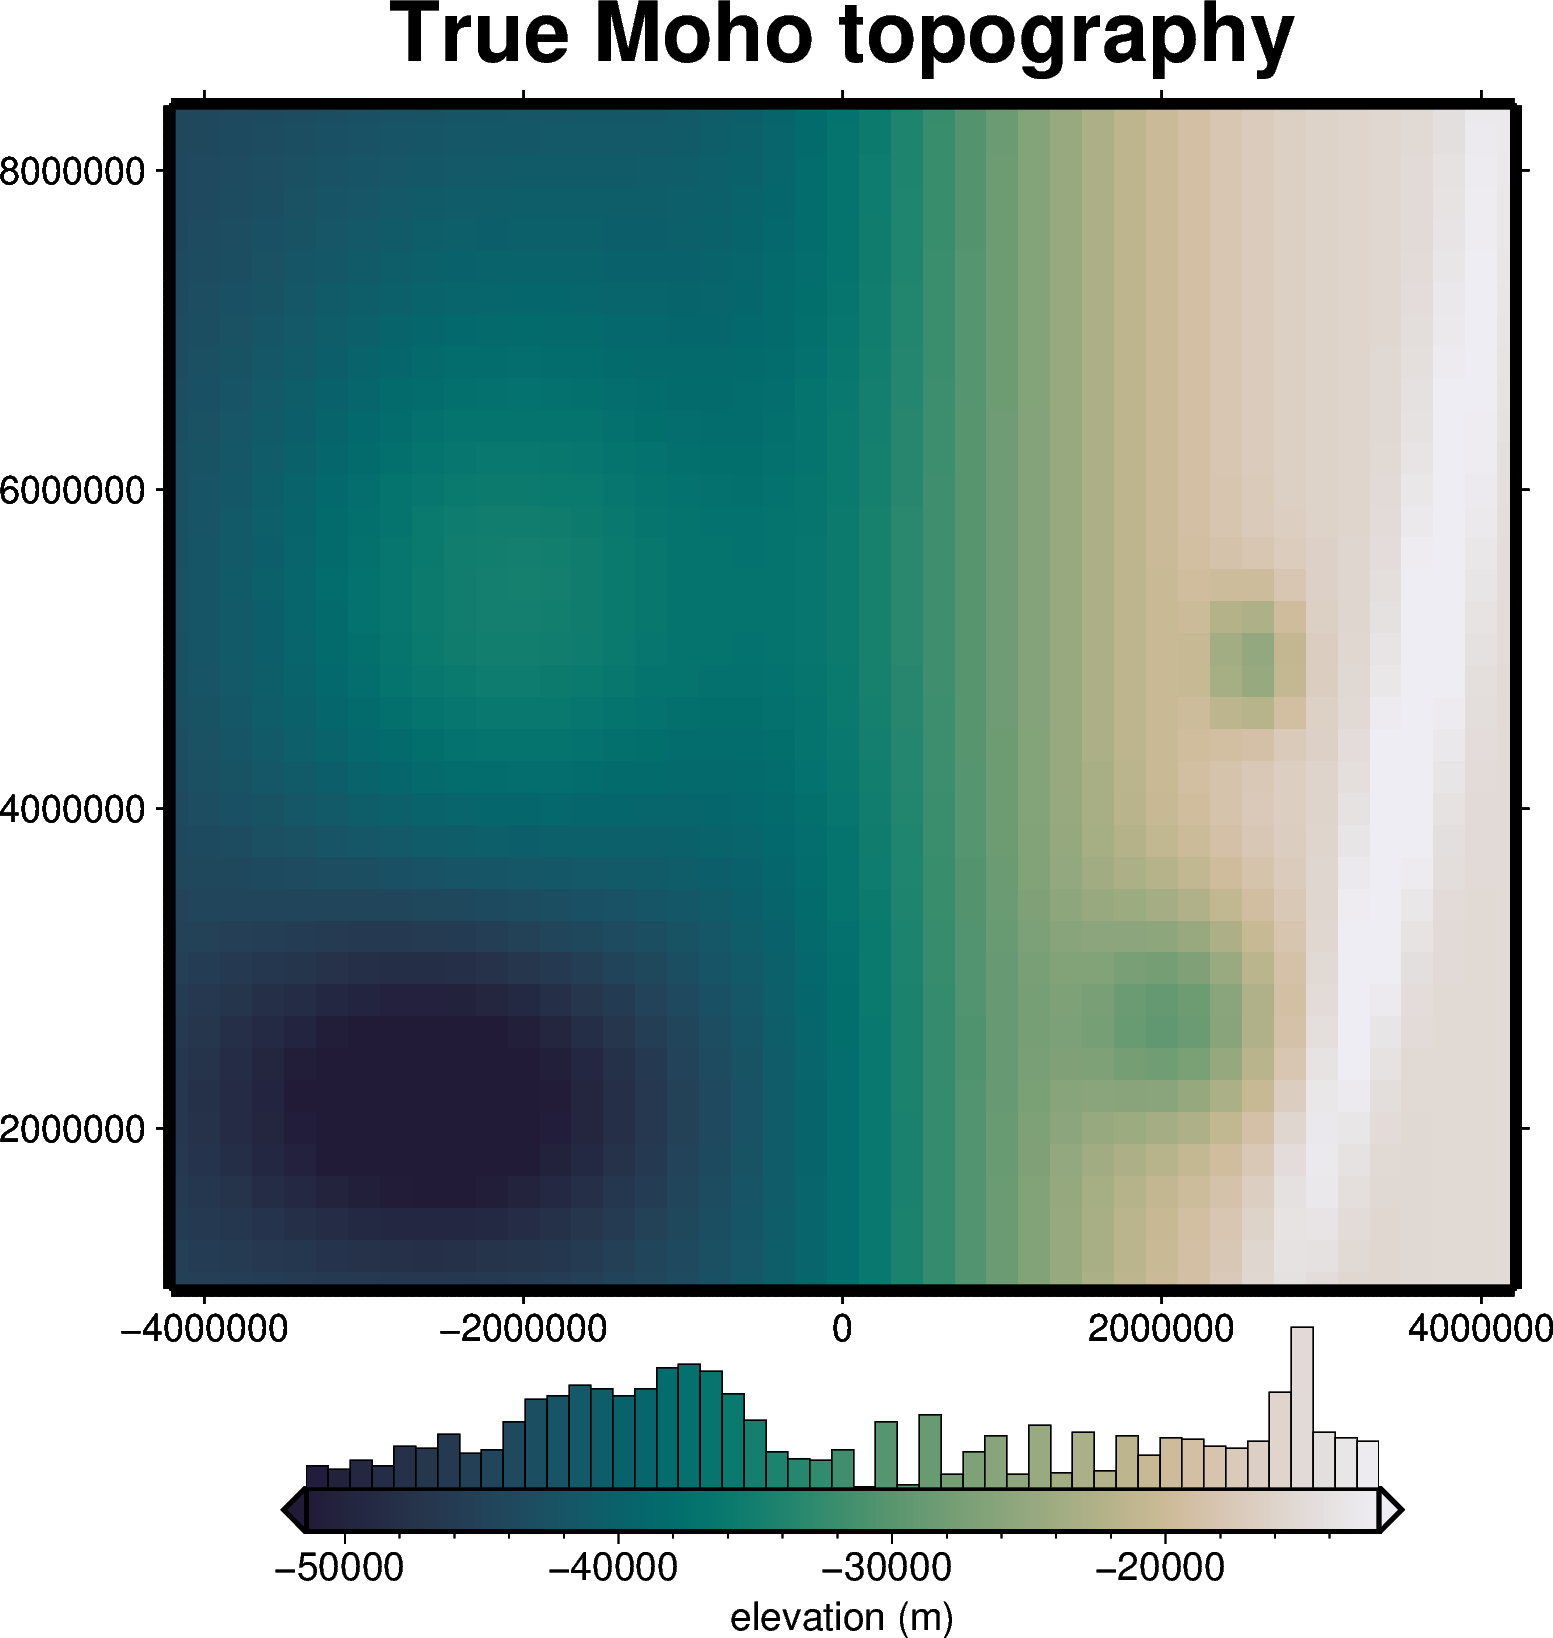

In [4]:
fig = ptk.plot_grid(
    true_moho.upward,
    fig_height=10,
    title="True Moho topography",
    hist=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_label="elevation (m)",
    robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Observed gravity data
We can know forward-model the effects of this topography and add some noise to make a synthetic observed gravity dataset.

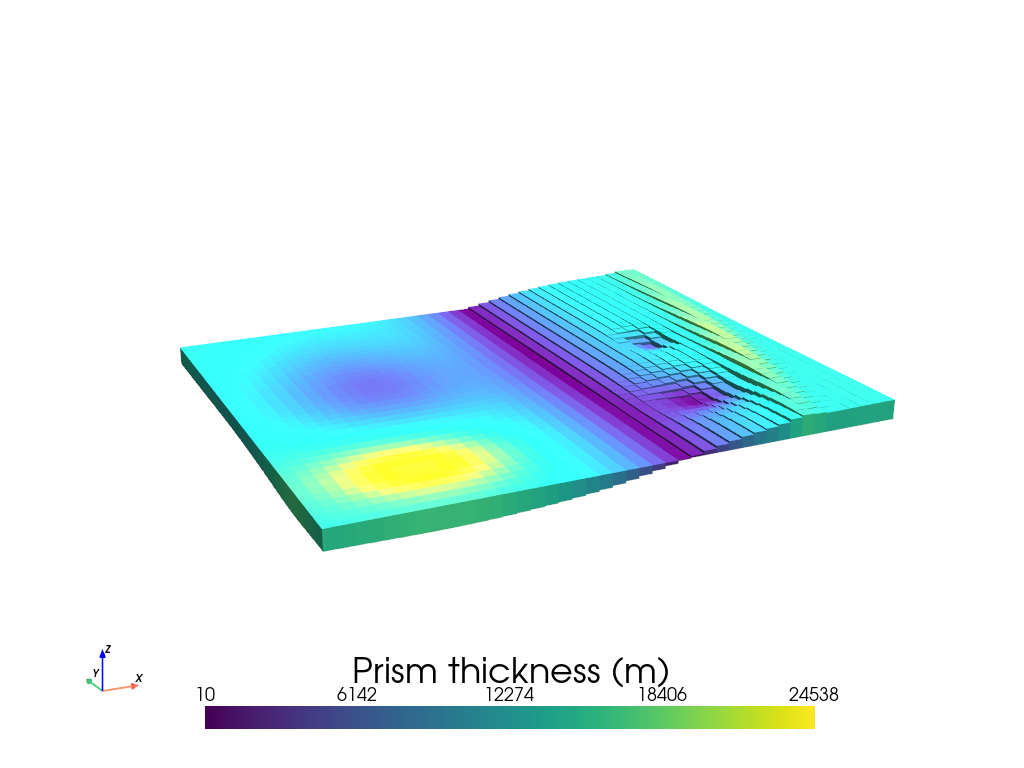

(200000.0, (-4200000.0, 4200000.0, 1000000.0, 8400000.0))

In [5]:
# Define the reference level (height in meters).
# This is the Moho depth of the Normal Earth
true_zref = -30e3

# The density contrast is negative if the relief is below the reference
true_density_contrast = 400

true_model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=true_moho,
)

true_model.inv.plot_model(
    color_by="thickness",
    log_scale=False,
    zscale=20,
)
true_model.spacing, true_model.region

In [6]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=true_model.region,
    spacing=true_model.spacing,
    pixel_register=False,
    extra_coords=50e3,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

grav_data = invert4geom.create_data(observations)

grav_data.inv.forward_gravity(true_model, "gravity_anomaly")

# contaminate gravity with random noise
grav_data["gravity_anomaly"], stddev = invert4geom.contaminate(
    grav_data.gravity_anomaly,
    stddev=5,
    percent=False,
    seed=0,
)

grav_data

<xarray.Dataset> Size: 27kB
Dimensions:          (northing: 38, easting: 43)
Coordinates:
  * northing         (northing) float64 304B 1e+06 1.2e+06 ... 8.2e+06 8.4e+06
  * easting          (easting) float64 344B -4.2e+06 -4e+06 ... 4e+06 4.2e+06
Data variables:
    upward           (northing, easting) float64 13kB 5e+04 5e+04 ... 5e+04
    gravity_anomaly  (northing, easting) float64 13kB -159.5 -189.4 ... 192.5
Attributes:
    region:        (-4200000.0, 4200000.0, 1000000.0, 8400000.0)
    spacing:       200000.0
    buffer_width:  800000.0
    inner_region:  (-3400000.0, 3400000.0, 1800000.0, 7600000.0)
    dataset_type:  data
    model_type:    prisms

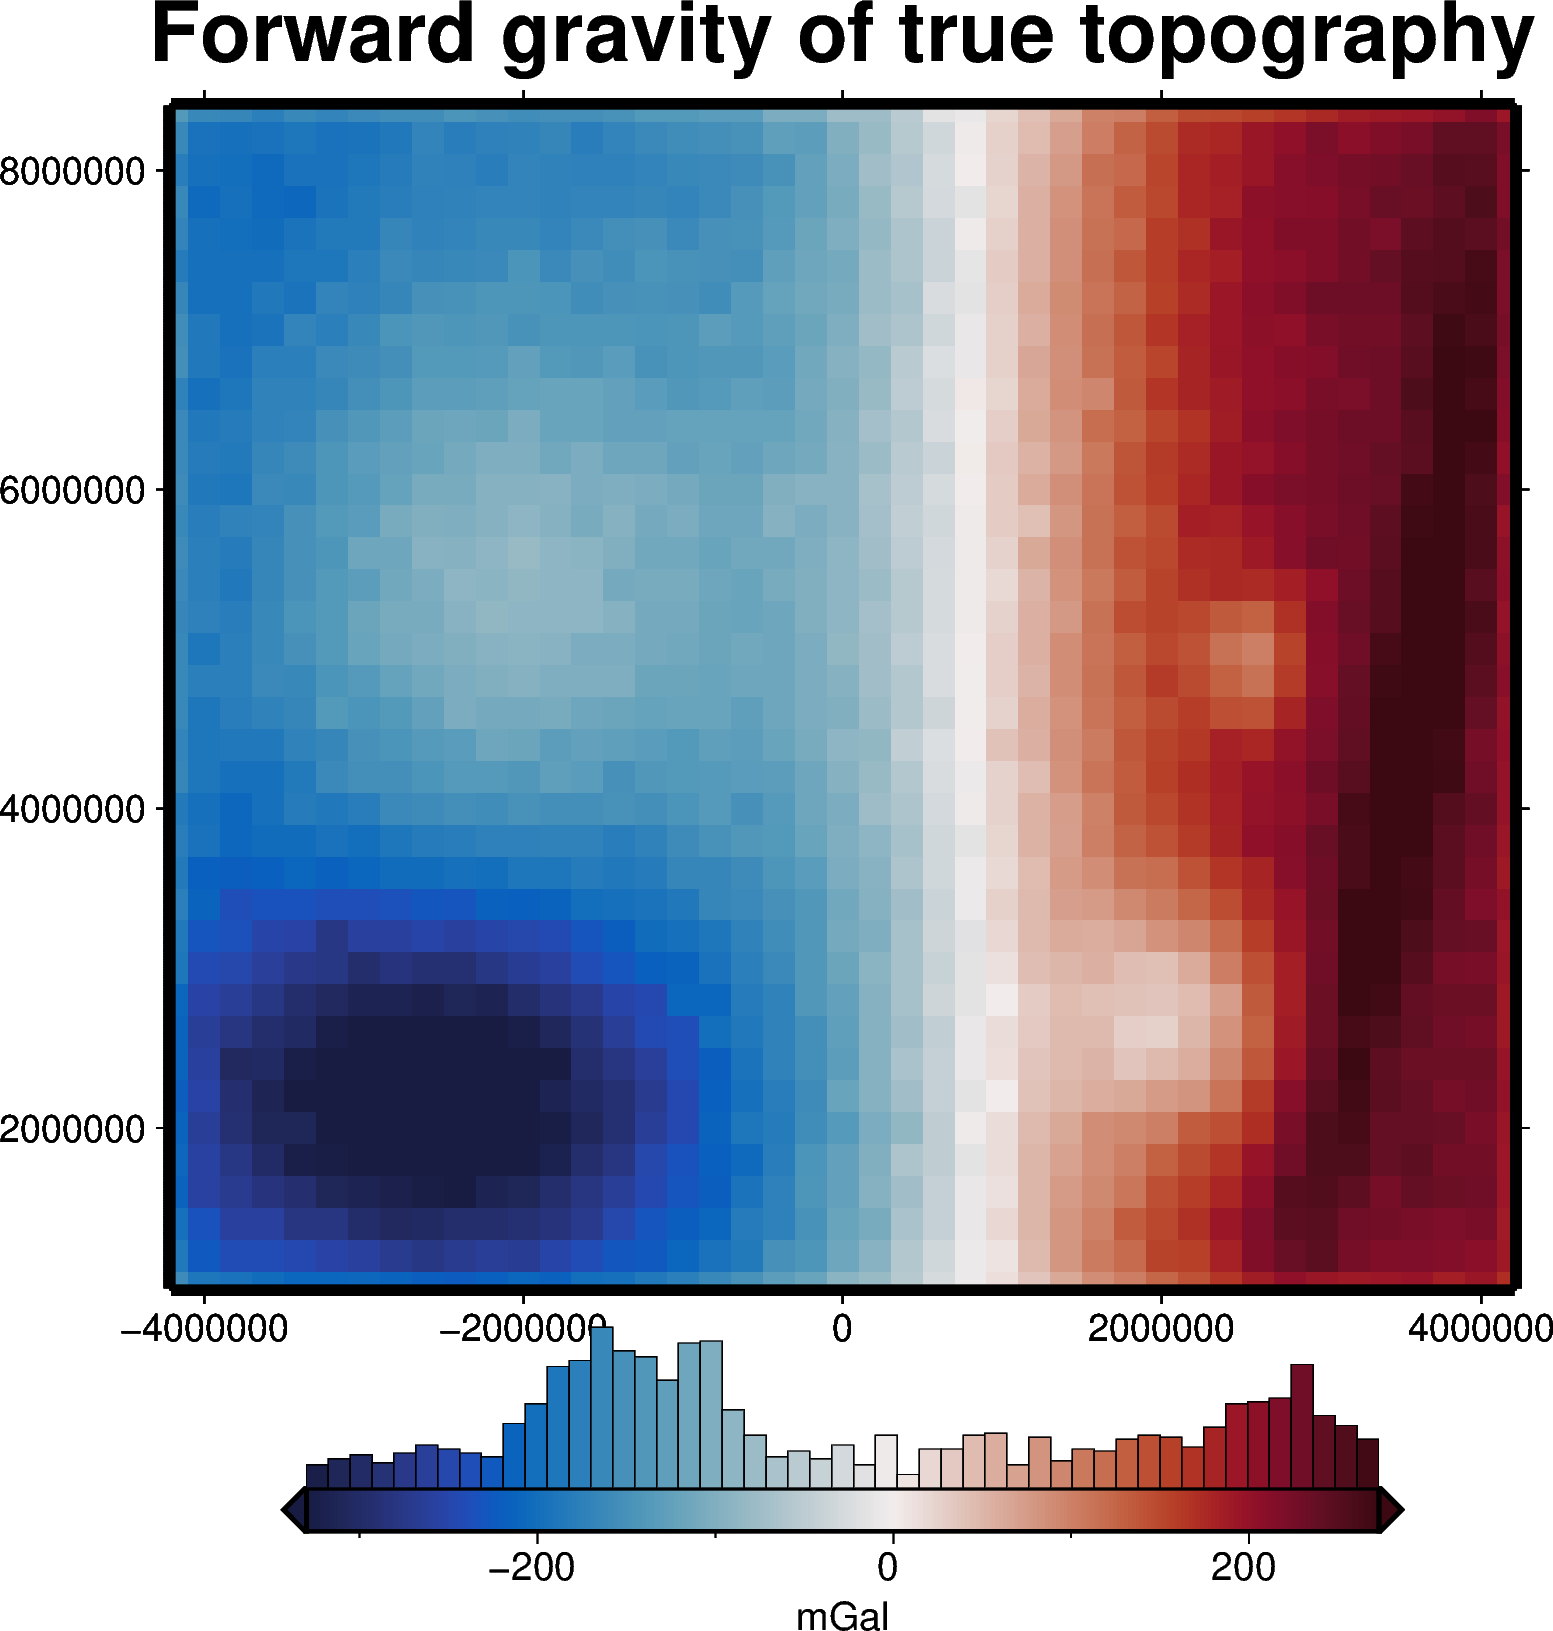

In [7]:
fig = ptk.plot_grid(
    grav_data.gravity_anomaly,
    fig_height=10,
    title="Forward gravity of true topography",
    hist=True,
    cmap="balance+h0",
    cbar_label="mGal",
    robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Starting model
Following the paper's approach, we create a starting model which uses the true values of the density contrast and reference level for the Moho. This is used during the damping parameter cross-validation.

In [8]:
grav_data.region, grav_data.inner_region

((-4200000.0, 4200000.0, 1000000.0, 8400000.0),
 (-3400000.0, 3400000.0, 1800000.0, 7600000.0))

In [9]:
# make a flat grid at the height of the zref
grid_coords = vd.grid_coordinates(region=true_model.region, spacing=true_model.spacing)
starting_topography = vd.make_xarray_grid(
    grid_coords, data=np.ones_like(grid_coords[0]) * true_zref + 1, data_names="upward"
)

In [10]:
model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=starting_topography,
)

In [11]:
# calculate the forward gravity of the initial model
grav_data.inv.forward_gravity(
    model,
    progressbar=True,
)

  0%|          | 0/1634 [00:00<?, ?it/s]

makecpt [ERROR]: Option T: min >= max


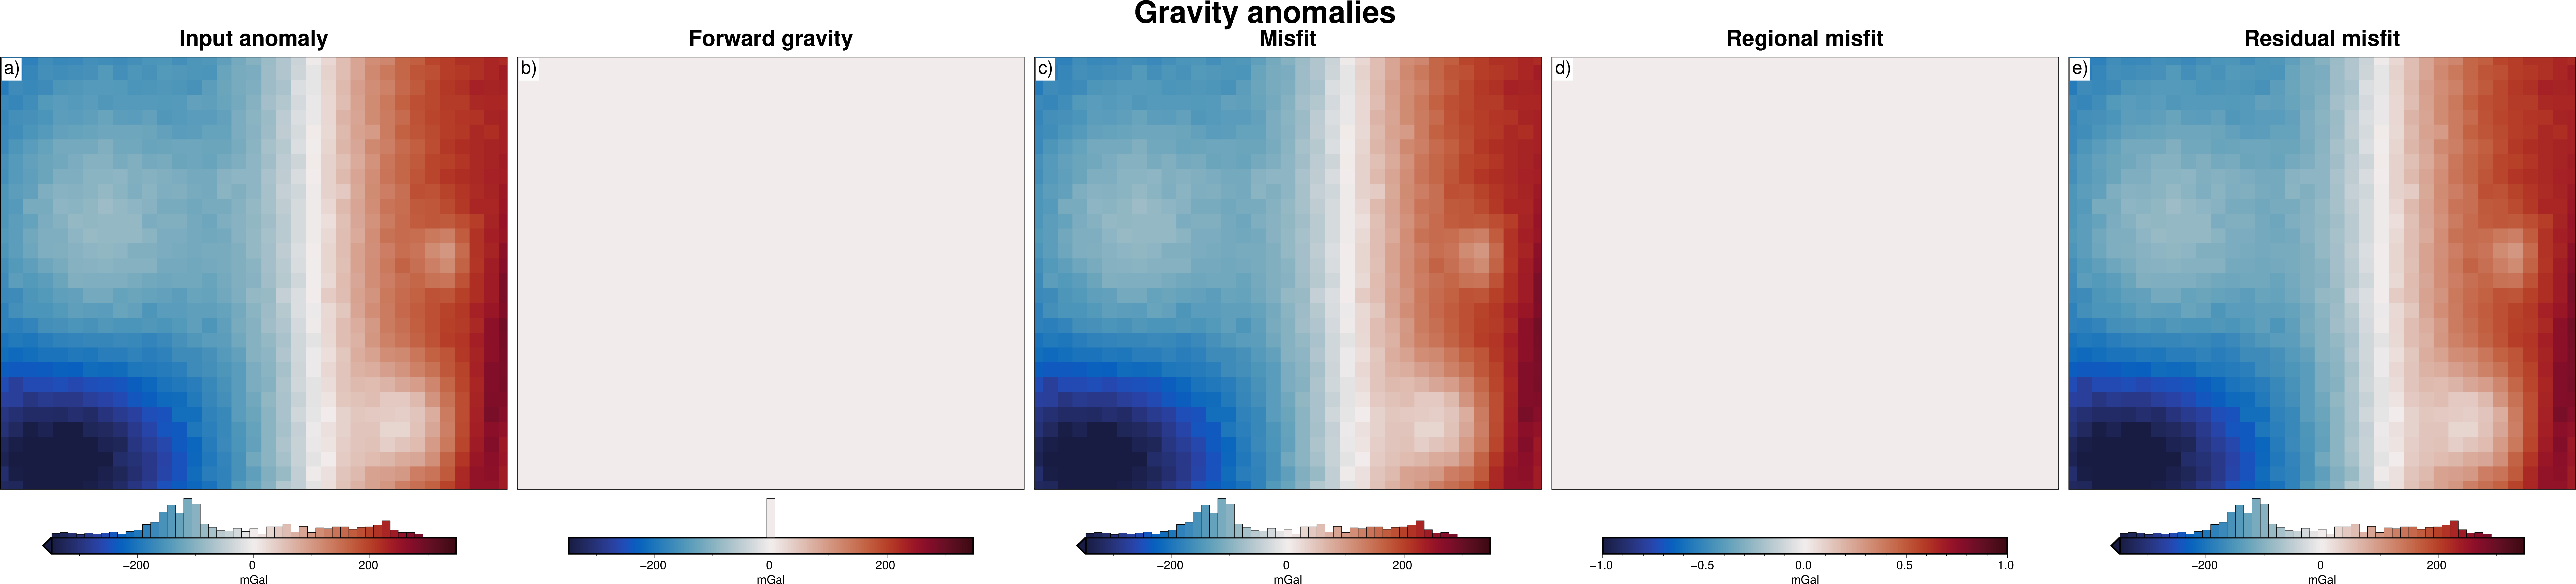

,northing,easting,upward,gravity_anomaly,forward_gravity,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,1000000.0,-4200000.0,50000.0,-159.504267,0.010690,-159.514958,0.0,-159.514958,0.010690,-159.514958,0.0,-159.514958
1,1000000.0,-4000000.0,50000.0,-189.355995,0.012327,-189.368322,0.0,-189.368322,0.012327,-189.368322,0.0,-189.368322
2,1000000.0,-3800000.0,50000.0,-194.033756,0.012667,-194.046423,0.0,-194.046423,0.012667,-194.046423,0.0,-194.046423
3,1000000.0,-3600000.0,50000.0,-202.348512,0.012806,-202.361318,0.0,-202.361318,0.012806,-202.361318,0.0,-202.361318
4,1000000.0,-3400000.0,50000.0,-210.171931,0.012880,-210.184811,0.0,-210.184811,0.012880,-210.184811,0.0,-210.184811
...,...,...,...,...,...,...,...,...,...,...,...,...
1629,8400000.0,3400000.0,50000.0,190.934934,0.012880,190.922054,0.0,190.922054,0.012880,190.922054,0.0,190.922054
1630,8400000.0,3600000.0,50000.0,192.746122,0.012806,192.733317,0.0,192.733317,0.012806,192.733317,0.0,192.733317
1631,8400000.0,3800000.0,50000.0,202.181446,0.012667,202.168779,0.0,202.168779,0.012667,202.168779,0.0,202.168779
1632,8400000.0,4000000.0,50000.0,217.167933,0.012327,217.155606,0.0,217.155606,0.012327,217.155606,0.0,217.155606


In [12]:
# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data.inv.plot_anomalies()
grav_data.inv.df

In [13]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.01,
    # set stopping criteria
    max_iterations=300,
    l2_norm_tolerance=2.2,  # gravity error is 5 mGal or L2-norm of ~2.2
    delta_l2_norm_tolerance=1.008,
)

In [14]:
inv.data.inv.df

,northing,easting,upward,gravity_anomaly,forward_gravity,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,1000000.0,-4200000.0,50000.0,-159.504267,0.010690,-159.514958,0.0,-159.514958,0.010690,-159.514958,0.0,-159.514958
1,1000000.0,-4000000.0,50000.0,-189.355995,0.012327,-189.368322,0.0,-189.368322,0.012327,-189.368322,0.0,-189.368322
2,1000000.0,-3800000.0,50000.0,-194.033756,0.012667,-194.046423,0.0,-194.046423,0.012667,-194.046423,0.0,-194.046423
3,1000000.0,-3600000.0,50000.0,-202.348512,0.012806,-202.361318,0.0,-202.361318,0.012806,-202.361318,0.0,-202.361318
4,1000000.0,-3400000.0,50000.0,-210.171931,0.012880,-210.184811,0.0,-210.184811,0.012880,-210.184811,0.0,-210.184811
...,...,...,...,...,...,...,...,...,...,...,...,...
1629,8400000.0,3400000.0,50000.0,190.934934,0.012880,190.922054,0.0,190.922054,0.012880,190.922054,0.0,190.922054
1630,8400000.0,3600000.0,50000.0,192.746122,0.012806,192.733317,0.0,192.733317,0.012806,192.733317,0.0,192.733317
1631,8400000.0,3800000.0,50000.0,202.181446,0.012667,202.168779,0.0,202.168779,0.012667,202.168779,0.0,202.168779
1632,8400000.0,4000000.0,50000.0,217.167933,0.012327,217.155606,0.0,217.155606,0.012327,217.155606,0.0,217.155606


In [15]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)
inv.data.inv.df

,northing,easting,test,upward,gravity_anomaly,forward_gravity,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,1000000.0,-4200000.0,False,50000.0,-159.504272,0.010690,-159.514954,0.0,-159.514954,0.010690,-159.514954,0.0,-159.514954
1,1000000.0,-4100000.0,True,50000.0,-176.003511,0.011590,-176.015089,0.0,-176.015089,0.011590,-176.015089,0.0,-176.015089
2,1000000.0,-4000000.0,False,50000.0,-189.356003,0.012327,-189.368317,0.0,-189.368317,0.012327,-189.368317,0.0,-189.368317
3,1000000.0,-3900000.0,True,50000.0,-193.040938,0.012590,-193.053521,0.0,-193.053521,0.012590,-193.053521,0.0,-193.053521
4,1000000.0,-3800000.0,False,50000.0,-194.033752,0.012667,-194.046417,0.0,-194.046417,0.012667,-194.046417,0.0,-194.046417
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6370,8400000.0,3800000.0,False,50000.0,202.181442,0.012667,202.168777,0.0,202.168777,0.012667,202.168777,0.0,202.168777
6371,8400000.0,3900000.0,True,50000.0,211.804831,0.012590,211.792240,0.0,211.792240,0.012590,211.792240,0.0,211.792240
6372,8400000.0,4000000.0,False,50000.0,217.167938,0.012327,217.155609,0.0,217.155609,0.012327,217.155609,0.0,217.155609
6373,8400000.0,4100000.0,True,50000.0,207.321564,0.011590,207.309970,0.0,207.309970,0.011590,207.309970,0.0,207.309970


## Damping parameter cross validation

### Get individual score

We will perform an inversion with a single damping value and calculate a `score` for it. The grid shows how to `score` is calculated, as the RMS difference between the predicted and observed gravity data.

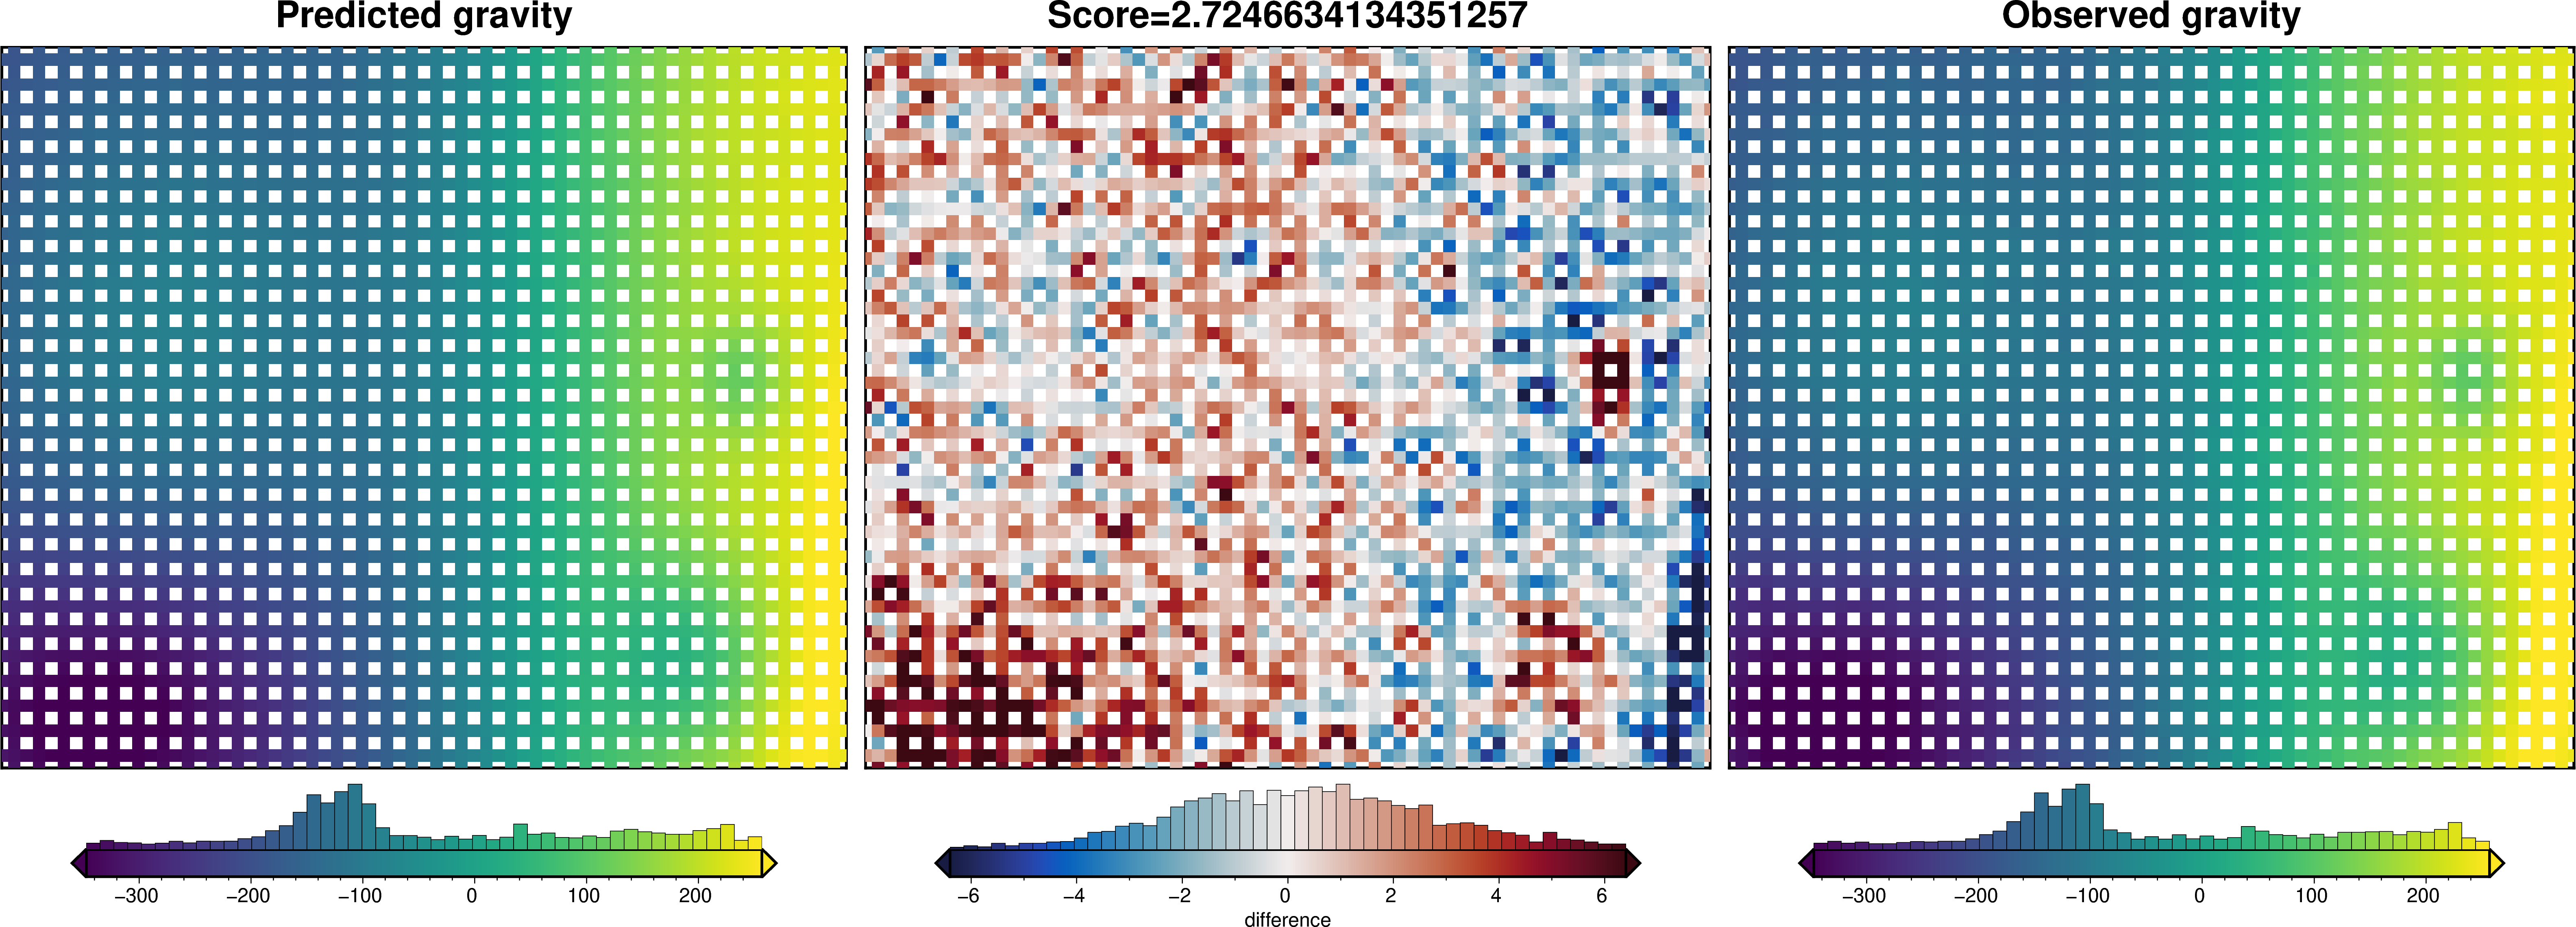

np.float64(2.7246634134351257)

In [16]:
# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
grav_optimization_object = inv.gravity_score(
    plot=True,
)
inv.gravity_best_score

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.0019831946384648285

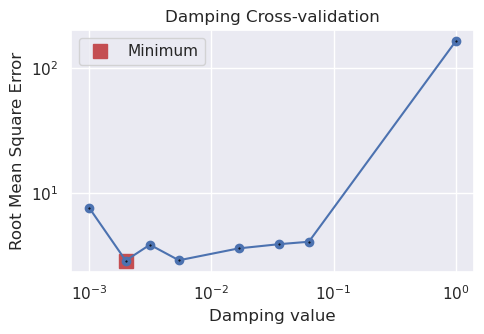

In [17]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(0.001, 1),
    n_trials=8,
    plot_scores=True,
    fname="../tmp/uieda_synthetic_damping_CV",
)
inv.solver_damping

In [18]:
damping_cv_obj.study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_damping,user_attrs_fname,system_attrs_fixed_params,state
0,0,7.585891,2026-02-09 19:00:54.202475,2026-02-09 19:00:57.281445,0 days 00:00:03.078970,0.001000,../tmp/uieda_synthetic_damping_CV_trial_0,{'damping': 0.001},COMPLETE
1,1,164.325549,2026-02-09 19:00:57.283031,2026-02-09 19:00:58.736840,0 days 00:00:01.453809,1.000000,../tmp/uieda_synthetic_damping_CV_trial_1,{'damping': 1},COMPLETE
2,2,2.883312,2026-02-09 19:00:58.738025,2026-02-09 19:01:01.200169,0 days 00:00:02.462144,0.001983,../tmp/uieda_synthetic_damping_CV_trial_2,NaN,COMPLETE
3,3,4.080380,2026-02-09 19:01:01.201487,2026-02-09 19:02:16.049671,0 days 00:01:14.848184,0.062714,../tmp/uieda_synthetic_damping_CV_trial_3,NaN,COMPLETE
4,4,3.610436,2026-02-09 19:02:16.062507,2026-02-09 19:02:20.123879,0 days 00:00:04.061372,0.016700,../tmp/uieda_synthetic_damping_CV_trial_4,NaN,COMPLETE
5,5,3.901876,2026-02-09 19:02:20.125317,2026-02-09 19:02:35.433507,0 days 00:00:15.308190,0.035779,../tmp/uieda_synthetic_damping_CV_trial_5,NaN,COMPLETE
6,6,2.899540,2026-02-09 19:02:35.435125,2026-02-09 19:02:36.990263,0 days 00:00:01.555138,0.005408,../tmp/uieda_synthetic_damping_CV_trial_6,NaN,COMPLETE
7,7,3.862374,2026-02-09 19:02:36.992137,2026-02-09 19:02:39.053644,0 days 00:00:02.061507,0.003130,../tmp/uieda_synthetic_damping_CV_trial_7,NaN,COMPLETE


The above plot shows the results of the damping parameter cross validation, and is equivalent to Figure 5e in the paper. The main difference is that we use a optimization approach instead of a grid search. This allows us to find the best value in fewer trials, as the parameter search space is quickly narrowed down. We performed 8 trials, compared to the 16 trials used in the paper.

## Inversion results

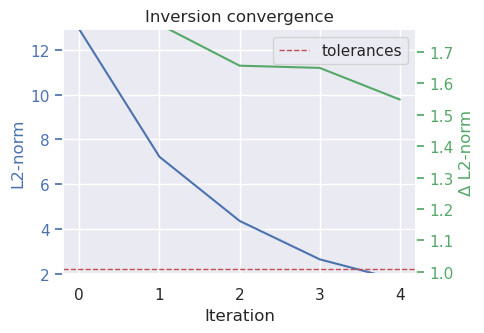

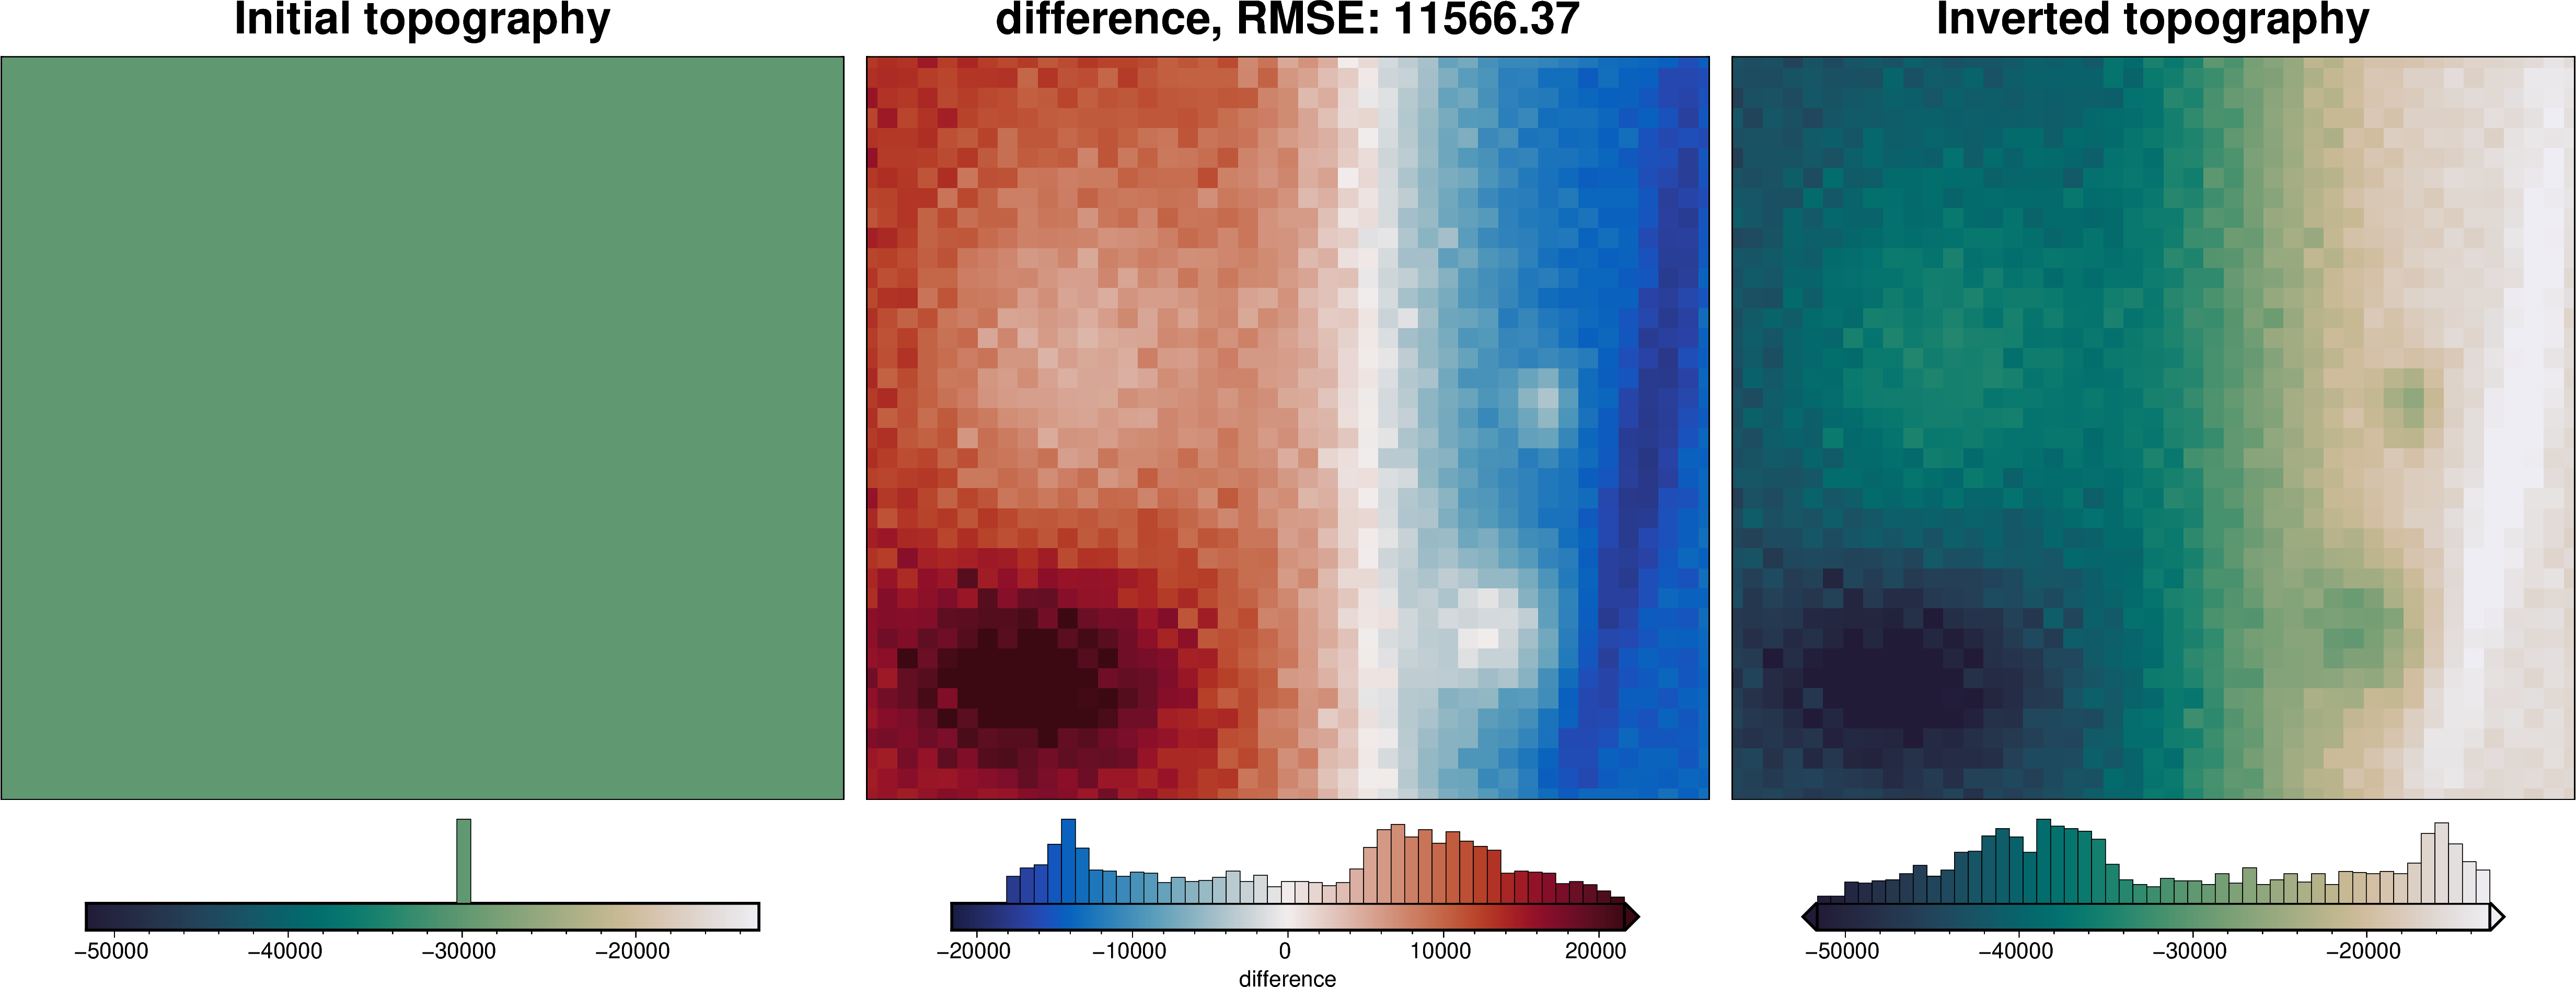

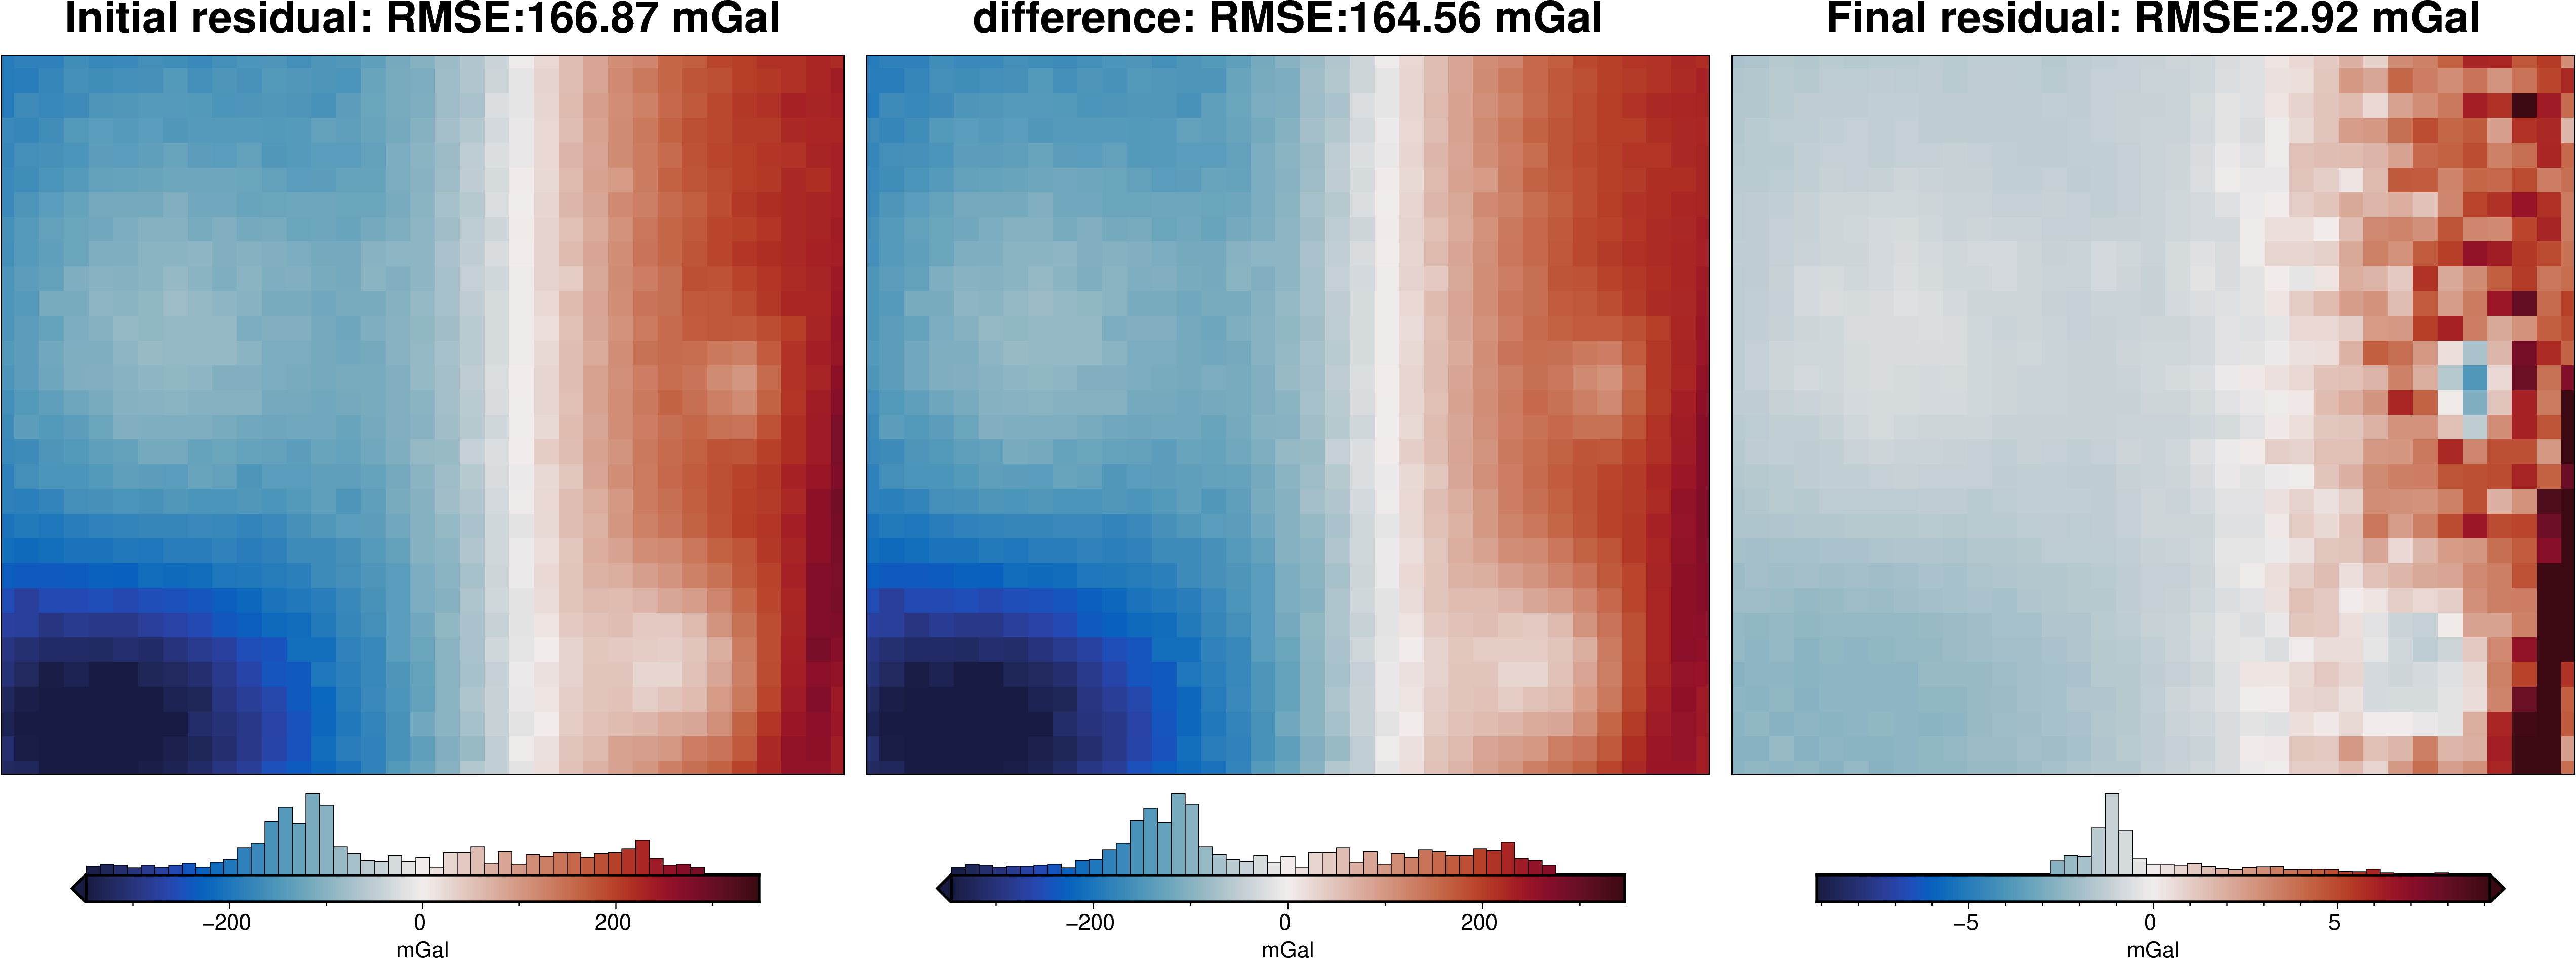

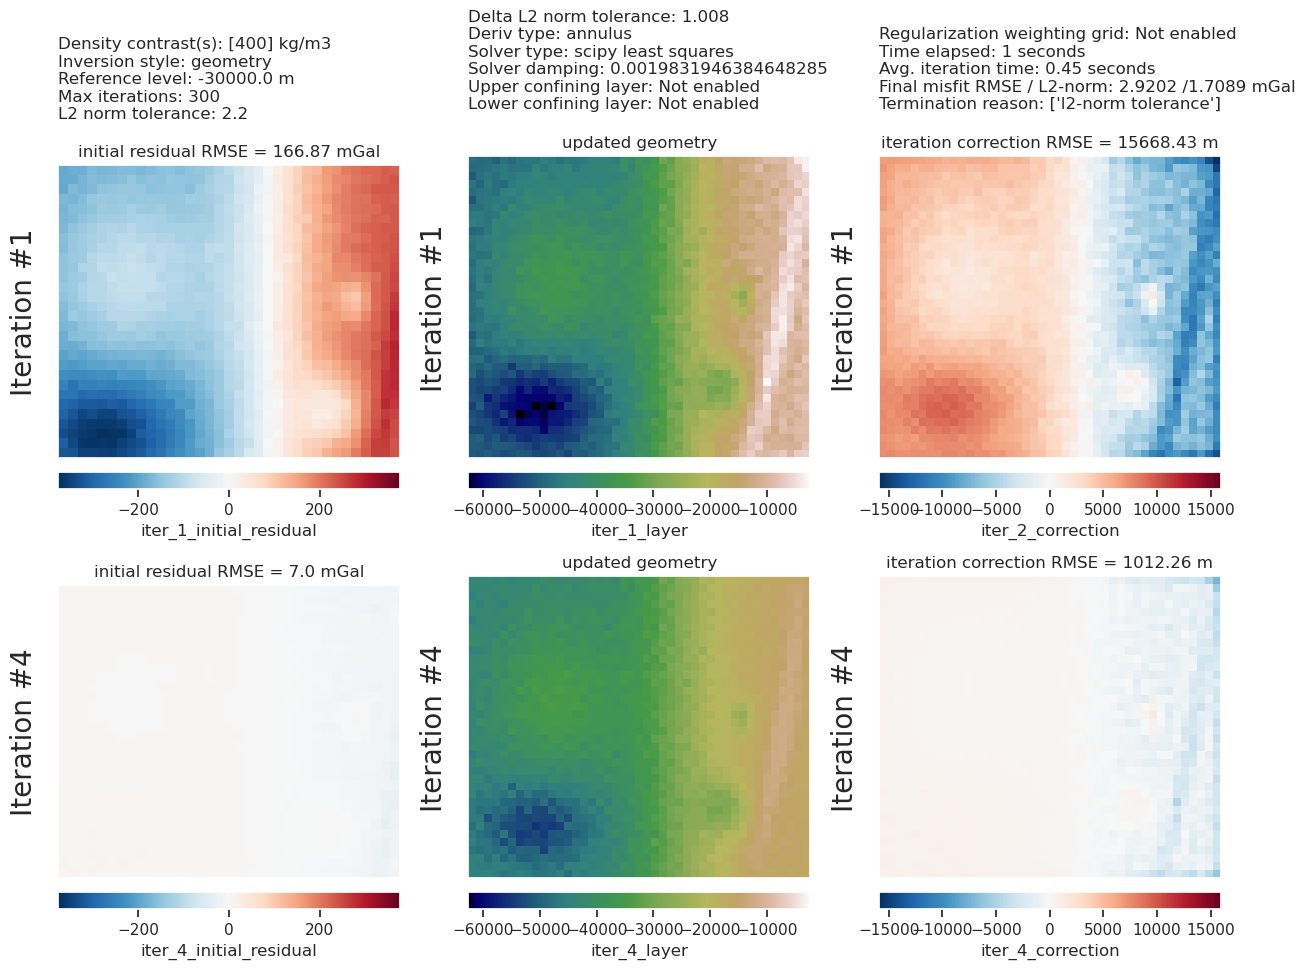

In [19]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

The top plot above compares gravity misfit before and after the inversion. The right subplot is equivalent to Figure 5c in the paper. 

The lower plot shows the iteration results of the inversion, and has all the parameter values and metadata at the top. From this, you can see the inversion terminated after 2 iterations due to the inversion reaching the set L2-norm tolerance. 

## Compare inverted with true topography
The plot below shows how the inversion performed. In the title, you can see the root mean squared difference (RMSE) between the true moho topography and the inversion topography, and the colorbar histogram shows the distribution of the differences. 

The errors appear to be normally distributed around 0, with max and min values of around 2km. Ueida et al. 2017 reported max and min errors of 2.19 and 2.13km, showing the similar effectiveness of these two inversions.

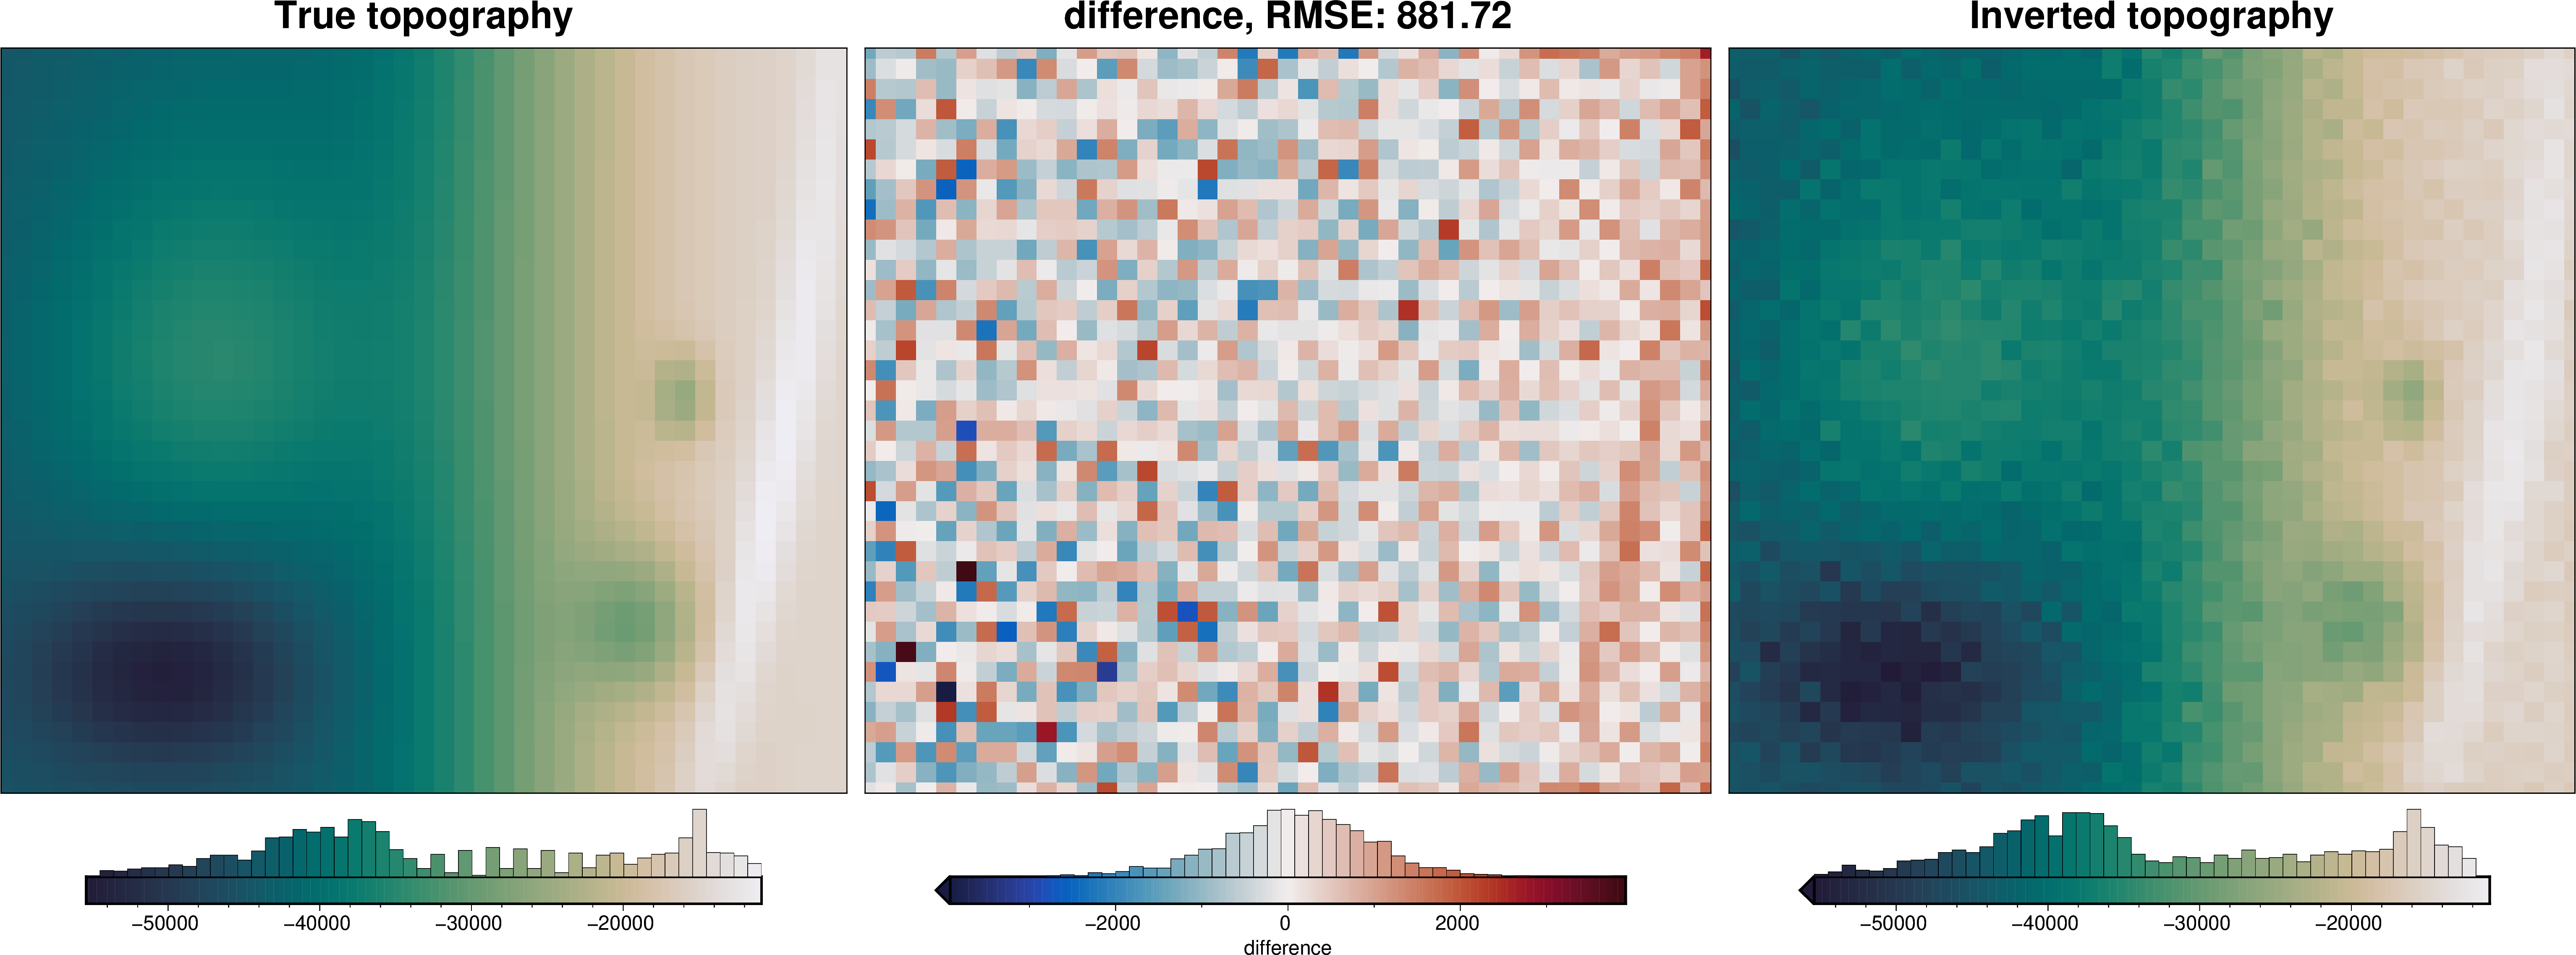

In [20]:
_ = ptk.grid_compare(
    true_moho.upward,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
)